# LPS and LCS in Human Chromosome 22

In [ ]:
using Plots
using Distributions
using DataFrames
using DelimitedFiles
using StringAlgorithms
using LaTeXStrings
using ProgressMeter
include("source/utils.jl")
include("source/palindrome.jl")
include("source/alignment.jl")
include("source/expectation.jl")
include("source/chromosome.jl")
include("source/io.jl")

### The Human Genome
Retrieve the sequences of the human chromosome from the UCSC Genome Browser's data:

- <a href="https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/p14/hg38.p14.fa.gz">HG38.p14</a> 

Unzip with `gzip -d hg38.p14.fa.gz` and move `hg38.p14.fa` to `/data`.

### HG38 Annotations
Retrieve the NCBI annotation for HG38:

- <a href="https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/genes/hg38.ncbiRefSeq.gtf.gz">HG38 NCBI RefSeq GTF</a>

Unzip with `gzip -d hg38.ncbiRefSeq.gtf.gz` and move `hg38.ncbiRefSeq.gtf` to `/data`.

### GffRead
The command-line tool GffRead can be downloaded and built from its github repository
- https://github.com/gpertea/gffread,

or installed using a package manager, e.g., `sudo apt install gffread`.

Convert the annotation `.gtf` to a `.gff`, and use it to extract reference sequences from the genome sequences. 
```
gffread -E data/hg38.ncbiRefSeq.gtf -o data/hg38.ncbiRefSeq.gff
gffread -w data/hg38.refseqs.fa -g data/hg38.p14.fa data/hg38.ncbiRefSeq.gff
```

In [ ]:
anno = readtable("data/hg38.ncbiRefSeq.gtf")
seqs = readsequences("data/hg38.refseqs.fa")
# locate all the transcripts (~ genes) in the annotation
mRNA_mask = anno[:, 3] .== "transcript"
# (check that the number of sequences is equal to the number of transcripts)
@assert sum(mRNA_mask) == length(seqs)
# locate transcripts for chromosome 22
mRNA = anno[mRNA_mask, :]
chr22_mask = mRNA[:, 1] .== "chr22"
# isolate sequences for chromosome 22
chr22_seqs = [seqs[i] for i=1:length(seqs) if chr22_mask[i] && length(seqs[i]) < 50_000]
chr22_seqs = filter(x -> !contains(x, 'N'), chr22_seqs)
writesequences("data/chr22.mRNA.fa", chr22_seqs)

### Introns and Intergenic regions

In [ ]:
chr22 = sequence(chromosome(22, readgenome("data/hg38.p14.fa"))[1]);
chr22_anno = anno[anno[:, 1] .== "chr22", :];
chr22_intron_anno = chr22_anno[chr22_anno[:,3] .== "3UTR" .|| chr22_anno[:,3] .== "5UTR", :]
chr22_intron_intervals = chr22_intron_anno[:,4:5]
chr22_introns = [chr22[start:stop] for (start,stop)=eachrow(chr22_intron_intervals)];
chr22_intron_samples = filter(x -> length(x) < 50_000, chr22_introns)
chr22_intron_samples = filter(x -> !contains(x, 'N'), chr22_intron_samples)
writesequences("data/chr22.intron-samples.fa", chr22_intron_samples)

In [ ]:
chr22_transcripts_anno = chr22_anno[chr22_anno[:, 3] .== "transcript", :]
chr22_transcript_intervals = Tuple.(eachrow(chr22_transcripts_anno[:, 4:5]))
# sample the negative space of the transcript intervals 
# for substrings with the same length distribution as `chr22_seqs`
target_distribution = vcat(length.(chr22_seqs), length.(chr22_intron_samples))
chr22_intergenic_samples = []
N = length(chr22)
for i=1:length(target_distribution)
    target_length = target_distribution[i]
    idx = rand(1:N-target_length)
    while contains(chr22[idx:idx+target_length-1], 'N') || any(interval_in.(idx,chr22_transcript_intervals)) || any(interval_in.(idx+target_length-1,chr22_transcript_intervals))
        idx = rand(1:N-target_length)
    end
    intergenic_seq = chr22[idx:idx+target_length-1]
    push!(chr22_intergenic_samples, intergenic_seq)
end
writesequences("data/chr22.intergenic-samples.fa", chr22_intergenic_samples)

# Masking repetitive regions with tantan
```
tantan -x N data/chr22.mRNA.fa > data/chr22.masked-mRNA.fa
tantan -x N data/chr22.intron-samples.fa > data/chr22.masked-intron-samples.fa
tantan -x N data/chr22.intergenic-samples.fa > data/chr22.masked-intergenic-samples.fa
```

### Compute LPS and LCS

In [ ]:
function llcs(x, y, progressmeter)
    next!(progressmeter)
    length(longestcommonsubstring(x, y)[1])
end
function llps(x, progressmeter)
    next!(progressmeter)
    length(longestpalindromicsubstring(x))
end
function generate_lps(x, resultpath)
    n = length(x)
    results = zeros(Int, n)
    p = Progress(n, 1, resultpath)
    @threads for i=1:n
        results[i] = llps(x[i], p)
    end
    lx = length.(x)
    print("writing LPS to ", resultpath)
    writeframe(resultpath, DataFrame([lx, results], ["length", "lps"]))
end
function generate_lcs(x, y, resultpath)
    @assert length(x) == length(y)
    n = length(x)
    results = zeros(Int, n)
    p = Progress(n, 1, resultpath)
    @threads for i=1:n
        results[i] = llcs(x[i], y[i], p)
    end
    lx = length.(x)
    ly = length.(y)
    print("writing LCS to ", resultpath)
    writeframe(resultpath, DataFrame([lx, ly, results], ["length1", "length2", "lcs"]))
end

In [ ]:
mRNA = uppercase.(readsequences("data/chr22.mRNA.fa"))
masked_mRNA = readsequences("data/chr22.masked-mRNA.fa")
masked_mRNA = replace.(masked_mRNA, 'N'=>"")
shuf_mRNA = shufflefast.(mRNA)
introns = uppercase.(readsequences("data/chr22.intron-samples.fa"))
masked_introns = readsequences("data/chr22.masked-intron-samples.fa")
masked_introns = replace.(masked_introns, 'N'=>"")
shuf_introns = shufflefast.(introns)
intergenics = uppercase.(readsequences("data/chr22.intergenic-samples.fa"))
masked_intergenics = readsequences("data/chr22.masked-intergenic-samples.fa")
masked_intergenics = replace.(masked_intergenics, 'N'=>"")
shuf_intergenics = shufflefast.(intergenics)
resultpaths = [
    "outputs/chr22.mRNA_shuf-mRNA.lcs",
    "outputs/chr22.intron_shuf-intron.lcs",
    "outputs/chr22.intergenic_shuf-intergenic.lcs",
    "outputs/chr22.shuf-mRNA.lps",
    "outputs/chr22.shuf-intron.lps",
    "outputs/chr22.shuf-intergenic.lps",
    "outputs/chr22.mRNA.lps",
    "outputs/chr22.intron.lps",
    "outputs/chr22.intergenic.lps",
    "outputs/chr22.masked-mRNA.lps",
    "outputs/chr22.masked-intron.lps",
    "outputs/chr22.masked-intergenic.lps",]

In [ ]:
generate_lcs(mRNA, shuf_mRNA, resultpaths[1])
generate_lcs(introns, shuf_introns, resultpaths[2])
generate_lcs(intergenics, shuf_intergenics, resultpaths[3])
generate_lps(shuf_mRNA, resultpaths[4])
generate_lps(shuf_introns, resultpaths[5])
generate_lps(shuf_intergenics, resultpaths[6])
generate_lps(mRNA, resultpaths[7])
generate_lps(introns, resultpaths[8])
generate_lps(intergenics, resultpaths[9])
generate_lps(masked_mRNA, resultpaths[10])
generate_lps(masked_introns, resultpaths[11])
generate_lps(masked_intergenics, resultpaths[12])

# Calculating λ₂

In [ ]:
coincidence(join(mRNA)),coincidence(join(masked_mRNA))

In [ ]:
coincidence(join(introns)),coincidence(join(masked_introns))

In [ ]:
coincidence(join(intergenics)),coincidence(join(masked_intergenics))

## Plot [python]

In [1]:
# coincidence frequency (λ₂) for our annotation of chr22
lambda2 = 0.25195

In [2]:
import matplotlib
matplotlib.__version__

'3.7.2'

In [3]:
import matplotlib.markers as markers
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stats
from time import time
from math import *
cluster = lambda data, parameter, lo, hi : [data[parameter==x] for x in range(lo,hi+1)]
_robust_cluster_means = lambda data_clusters : [stats.mean(cluster) if len(cluster)>0 else -1 for cluster in data_clusters]
def robust_cluster_means(clusters, width=1):
    if width == 1:
        return _robust_cluster_means(clusters)
    else:
        n = len(clusters)
        m = ceil(n / width)
        new_clusters = [[] for _ in range(m)]
        for i in range(m):
            for j in range(i, min(i + width, n)):
                new_clusters[i].extend(list(clusters[j]))
        return _robust_cluster_means(new_clusters)
def scatter_cluster_means(axis, frame, datakey, paramkey, lo, hi, color, marker, label, width=10):
    clusters = cluster(frame[datakey], frame[paramkey], lo, hi)
    x = robust_cluster_means(clusters, width=width)
    m = len(x)
    y = [width*i for i in range(0,m)]
    axis.scatter(y, x, 60, label=label, marker=marker, facecolors='none', edgecolors=color)
def plot_expected_lcs(axis, lambda2, lo, hi, color):
    x = list(range(lo,hi+1))
    axis.plot(x, [exp_lcs(n, lambda2) for n in x], 
              color=color, linewidth=1, label="𝔼[LCS] = 2log(n)/log(1/λ₂)")
def plot_expected_lps(axis, lambda2, lo, hi, color):
    x = list(range(lo,hi+1))
    axis.plot(x, [exp_lps(n, lambda2) for n in x], 
              color=color, linewidth=1, label="𝔼[LPS] = 𝔼[LCS] + 1")
def setup_axis(axis,xlo=100,xhi=50_000,ylo=0,yhi=40,legsize=100):
    axis.set_xlim(xlo,xhi)
    axis.set_xscale("log")
    axis.set_xlabel("Sequence Length", fontsize=100, labelpad=30)
    axis.set_ylim(ylo,yhi)
    axis.set_yscale("linear")
    axis.set_ylabel("Average Substring Length", fontsize=100, labelpad=50)
    axis.tick_params(axis='both', which='major', labelsize=50)
    axis.set_yticks([1,5,10,15,20,25,30,35,40])
    leg = axis.legend(prop={'size':legsize}, markerscale=legsize/10, loc="upper left")
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
        lh.set_linewidth(10)
def setup_axis2(axis,xlo=100,xhi=50_000,ylo=0,yhi=25,legsize=100):
    axis.set_xlim(xlo,xhi)
    axis.set_xscale("log")
    axis.set_xlabel("Sequence Length", fontsize=100, labelpad=30)
    axis.set_ylim(ylo,yhi)
    axis.set_yscale("linear")
    axis.set_ylabel("Average Substring Length", fontsize=100, labelpad=50)
    axis.tick_params(axis='both', which='major', labelsize=50)
    axis.set_yticks([1,5,10,15,20,25,30,35,40])
    leg = axis.legend(prop={'size':legsize}, markerscale=legsize/10, loc="upper left")
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
        lh.set_linewidth(10)

In [9]:
resultpaths = [
    "outputs/chr22.mRNA_shuf-mRNA.lcs",
    "outputs/chr22.intron_shuf-intron.lcs",
    "outputs/chr22.intergenic_shuf-intergenic.lcs",
    "outputs/chr22.shuf-mRNA.lps",
    "outputs/chr22.shuf-intron.lps",
    "outputs/chr22.shuf-intergenic.lps",
    "outputs/chr22.mRNA.lps",
    "outputs/chr22.intron.lps",
    "outputs/chr22.intergenic.lps",
    "outputs/chr22.masked-mRNA.lps",
    "outputs/chr22.masked-intron.lps",
    "outputs/chr22.masked-intergenic.lps",]
(lcs_mRNA, 
 lcs_intron, 
 lcs_intergenic, 
 lps_shuf_mRNA,
 lps_shuf_intron,
 lps_shuf_intergenic,
 lps_mRNA,
 lps_intron,
 lps_intergenic,
 lps_masked_mRNA,
 lps_masked_intron,
 lps_masked_intergenic,
) = [pd.read_csv(x) for x in resultpaths]

lcsmaroon = "#8a1414"
lcsmaroon_light = "#d11111"
lcsmaroon_dark = "#571414"
sprotblue = "#0000ff"
sprotblue_light = "#5a5aff"
sprotblue_dark = "#000097"
shufred = "#ff8800"
shufred_light = "#ffba6d"
shufred_dark = "#7a4000"
maskgreen = maskblue = "#228FAF"
maskgreen_light = maskblue_light = "#15bdee"
maskgreen_dark = maskblue_dark = "#195364"

lo = lo_protein = lo_rna = lo_pseudogene = 1
hi = hi_protein = hi_rna = hi_pseudogene = int(50_000)

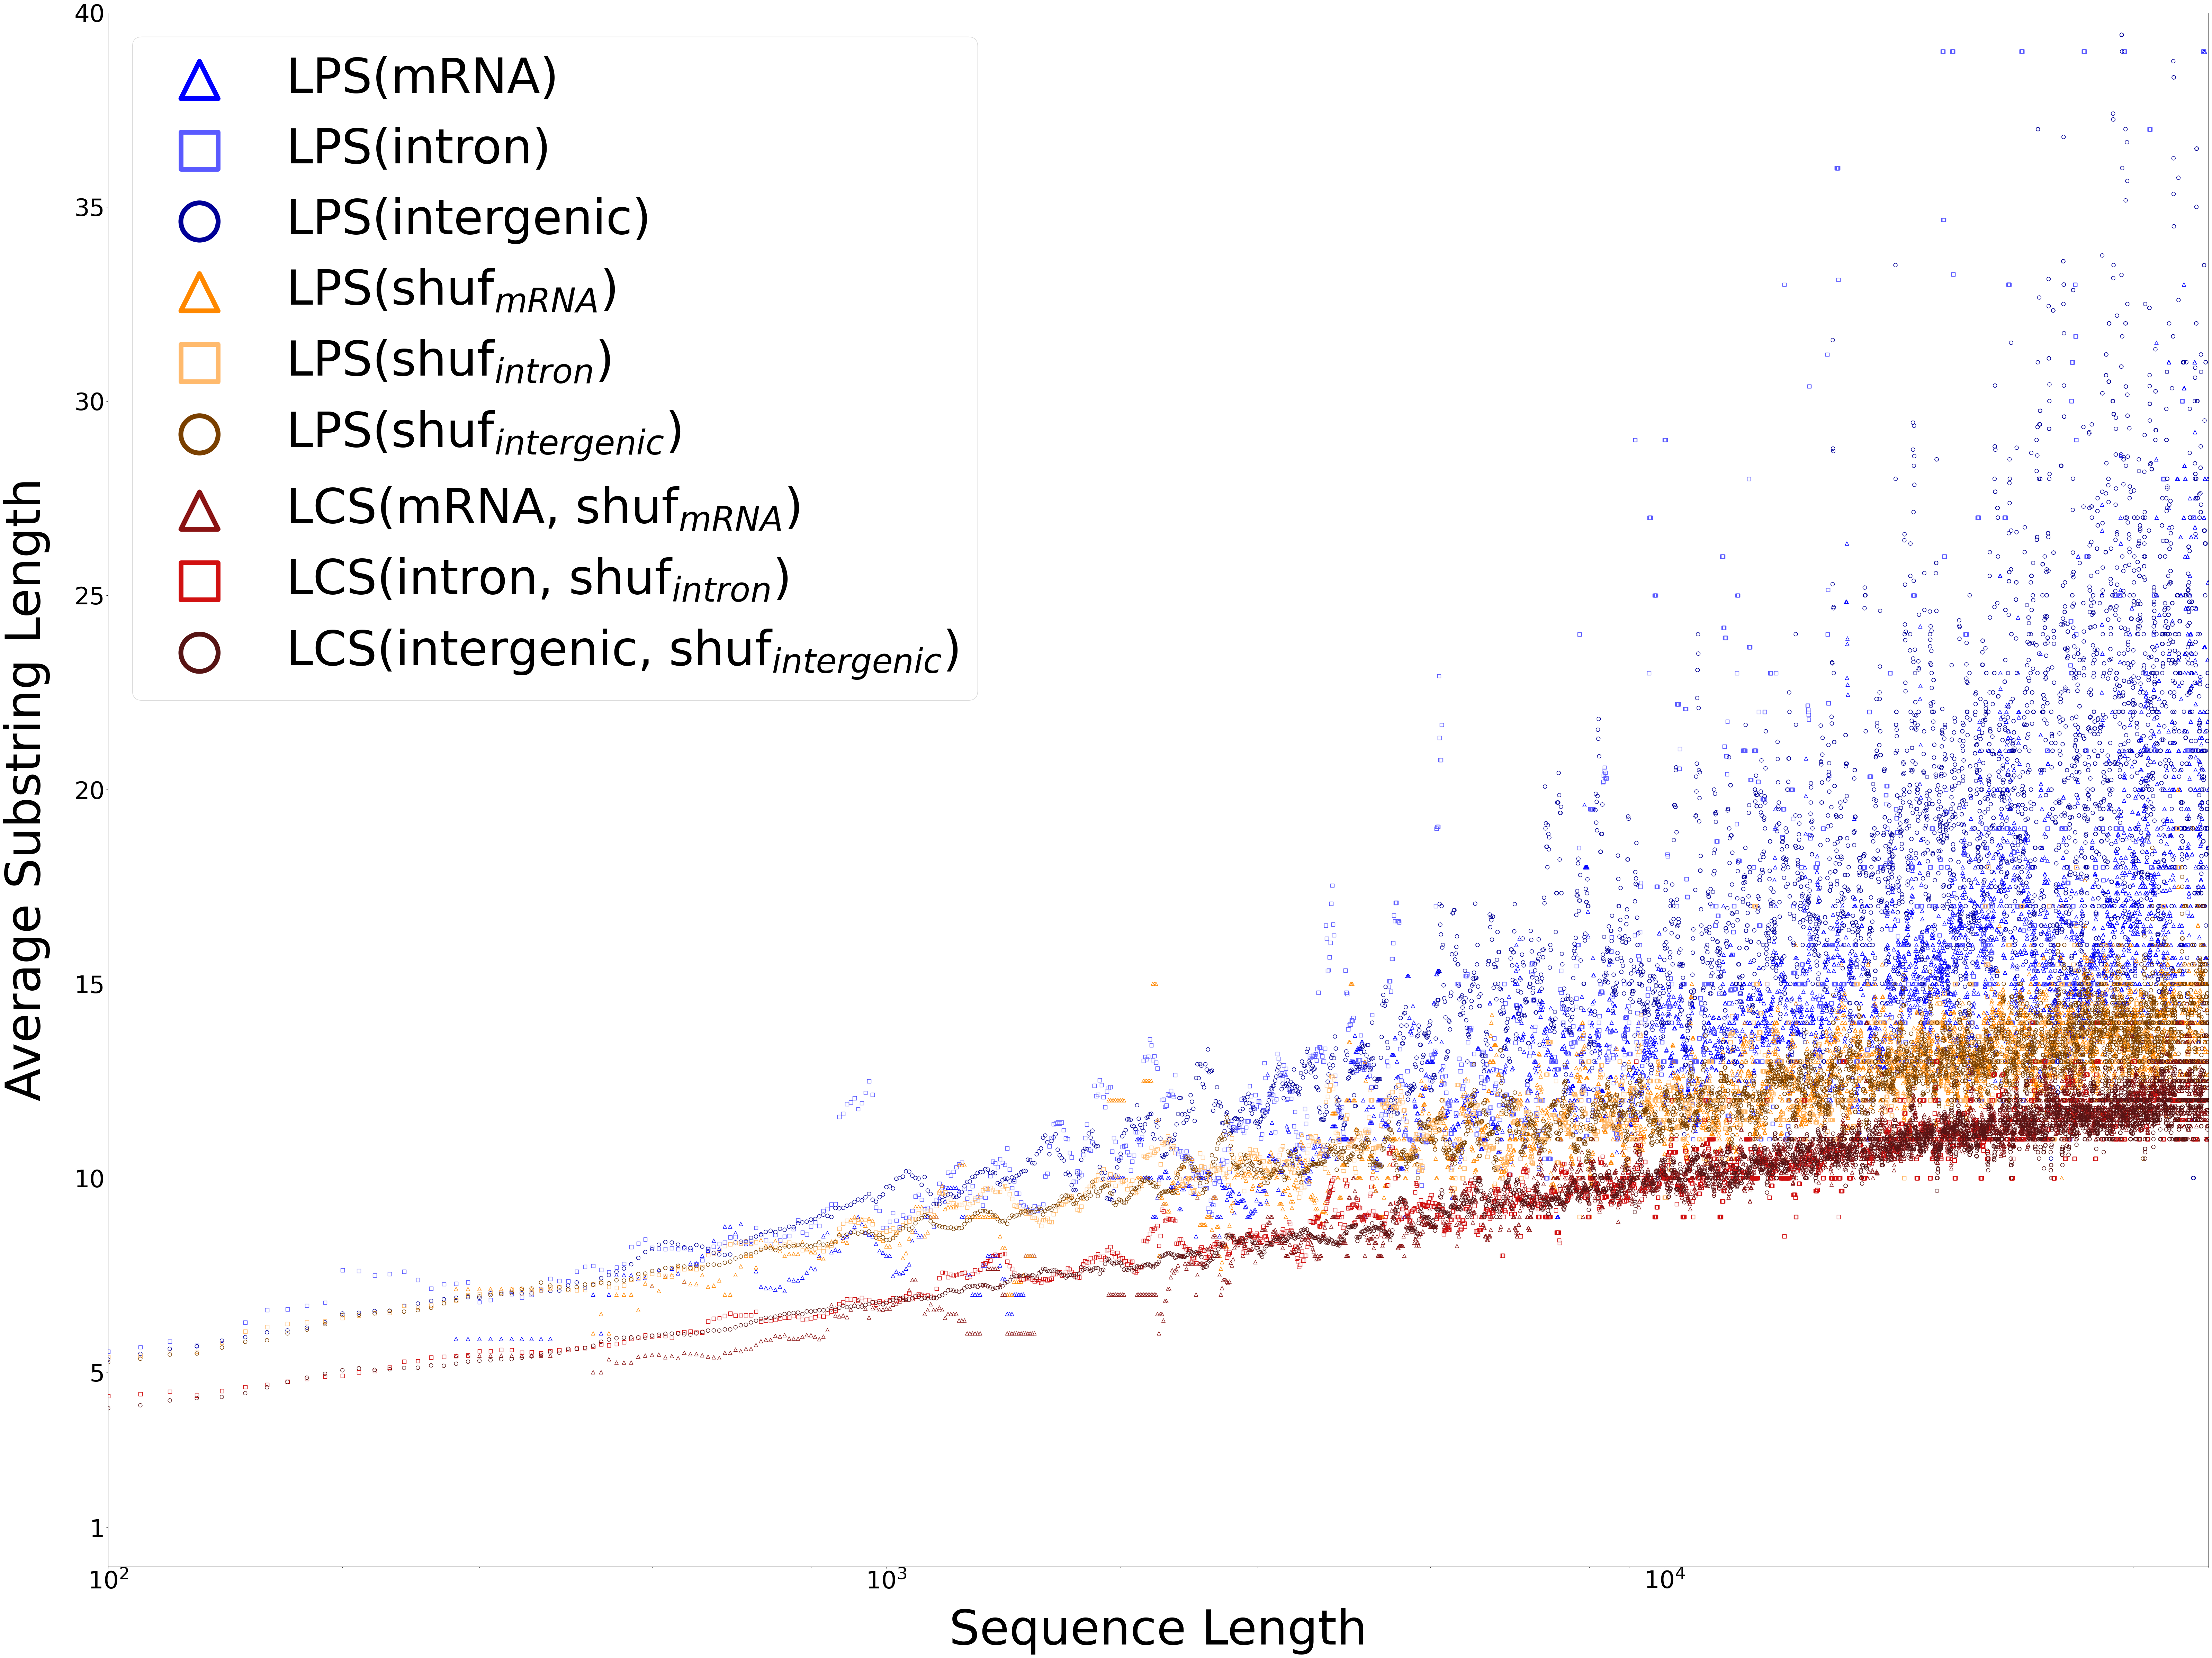

In [10]:
fig, ax = plt.subplots(dpi=100,figsize=(64,48))

scatter_cluster_means(ax, lps_mRNA, "lps", "length", lo_protein, hi_protein,
                      sprotblue, '^', "LPS(mRNA)")

scatter_cluster_means(ax, lps_intron, "lps", "length", lo_rna, hi_rna,
                      sprotblue_light, 's', "LPS(intron)")

scatter_cluster_means(ax, lps_intergenic, "lps", "length", lo_pseudogene, hi_pseudogene,
                      sprotblue_dark, 'o', "LPS(intergenic)")


scatter_cluster_means(ax, lps_shuf_mRNA, "lps", "length", lo_protein, hi_protein,
                      shufred, '^', "LPS(shuf$_{mRNA}$)")

scatter_cluster_means(ax, lps_shuf_intron, "lps", "length", lo_rna, hi_rna,
                      shufred_light, 's', "LPS(shuf$_{intron}$)")

scatter_cluster_means(ax, lps_shuf_intergenic, "lps", "length", lo_pseudogene, hi_pseudogene,
                      shufred_dark, 'o', "LPS(shuf$_{intergenic}$)")


scatter_cluster_means(ax, lcs_mRNA, "lcs", "length1", lo_protein, hi_protein,
                      lcsmaroon, '^', "LCS(mRNA, shuf$_{mRNA}$)")

scatter_cluster_means(ax, lcs_intron, "lcs", "length1", lo_rna, hi_rna,
                      lcsmaroon_light, 's', "LCS(intron, shuf$_{intron}$)")

scatter_cluster_means(ax, lcs_intergenic, "lcs", "length1", lo_pseudogene, hi_pseudogene,
                      lcsmaroon_dark, 'o', "LCS(intergenic, shuf$_{intergenic}$)")


setup_axis(ax)
plt.tight_layout()
plt.savefig("figures/LPSLCS_Chromosome22_a.pdf")

In [ ]:
fig, ax = plt.subplots(dpi=100,figsize=(64,48))

scatter_cluster_means(ax, lps_masked_mRNA, "lps", "length", lo_protein, hi_protein,
                      maskgreen, '^', "LPS(masked mRNA)")
scatter_cluster_means(ax, lps_masked_intron, "lps", "length", lo_rna, hi_rna,
                      maskgreen_light, 's', "LPS(masked intron)")
scatter_cluster_means(ax, lps_masked_intergenic, "lps", "length", lo_pseudogene, hi_pseudogene,
                      maskgreen_dark, 'o', "LPS(masked intergenic)")

scatter_cluster_means(ax, lps_shuf_mRNA, "lps", "length", lo_protein, hi_protein,
                      shufred, '^', "LPS(shuf$_{mRNA}$)")
scatter_cluster_means(ax, lps_shuf_intron, "lps", "length", lo_rna, hi_rna,
                      shufred_light, 's', "LPS(shuf$_{intron}$)")
scatter_cluster_means(ax, lps_shuf_intergenic, "lps", "length", lo_pseudogene, hi_pseudogene,
                      shufred_dark, 'o', "LPS(shuf$_{intergenic}$)")

setup_axis2(ax)
plt.tight_layout()
plt.savefig("figures/LPSLCS_Chromosome22_b.pdf")